In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from plot_utils import plotCategoricalPerformance
import os
import seaborn as sns
import pandas as pd
from tf_util.families import family_from_str
from plot_util import EFN_model_df, find_last_ind, get_latest_diagnostics
from efn_util import setup_IO, find_convergence, model_opt_hps

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

basedir = '/Users/sbittner/Documents/efn/';
dir_str = 'dim_sweep';

exp_fam = 'dirichlet';

datadir = '/Users/sbittner/Documents/efn/results/dim_sweep/';
D = 50;
model = 'EFN';
L = 7;
give_hint = False;
        
ds = 0;
K = 100;
M = 1000;

rs = 0;
wsize = 50;
delta_thresh = 1e-10;

max_iters = 1000000;
min_iters = 50000;
check_rate = 100;
max_checks = np.int(max_iters // check_rate);
min_checks = np.int(min_iters // check_rate);

        
if (D >= 20):
    min_iters = 100000;
else:
    min_iters = 50000;


fam_class = family_from_str(exp_fam);
family = fam_class(D);
D_Z, num_suff_stats, num_param_net_inputs, num_T_x_inputs = family.get_efn_dims('eta', give_hint);


TIF_flow_type, nlayers, scale_layer, lr_order = model_opt_hps(exp_fam, D);
param_net_hps = {'L':L};

flow_dict = {'latent_dynamics':None, \
             'scale_layer':scale_layer, \
             'TIF_flow_type':TIF_flow_type, \
             'repeats':nlayers};
dist_info = {'dist_seed':ds};
model_dir = setup_IO(family, model, dir_str, 'eta', K, M, flow_dict, \
                             param_net_hps, give_hint, rs, dist_info);
savedir = basedir + model_dir;
fname = savedir + 'results.npz';
try:
    npzfile = np.load(fname);
except:
    print('Error! Issue reading %s' % model_dir);

test_elbos = npzfile['test_elbos'];
last_ind = find_last_ind(test_elbos);
mean_test_elbos = np.mean(test_elbos, 1);
ind = find_convergence(mean_test_elbos, last_ind+1, wsize, delta_thresh);
print('last in before zeros', last_ind);
print('convergence ind', ind);
if (ind is None or (not npzfile['converged'])):
    print('Hasnt converged: %s' % fname);
    ind = mean_test_elbos.shape[0];
else:
    print('%s was fine' % model_dir);
    ind = max(ind, min_checks);
final_ind = ind;


diagnostic_str = 'train' if (model == 'EFN1') else 'test';

mean_elbos = np.mean(npzfile['%s_elbos' % diagnostic_str], 1)[:ind];
std_elbos = np.std(npzfile['%s_elbos' % diagnostic_str], 1)[:ind];

mean_KLs = np.mean(npzfile['%s_KLs' % diagnostic_str], 1)[:ind];
std_KLs = np.std(npzfile['%s_KLs' % diagnostic_str], 1)[:ind];

mean_R2s = np.mean(npzfile['%s_R2s' % diagnostic_str], 1)[:ind];
std_R2s = np.std(npzfile['%s_R2s' % diagnostic_str], 1)[:ind];
check_rate = npzfile['check_rate'];
print(mean_elbos.shape, mean_R2s.shape);

last in before zeros 3770
convergence ind 3770
results/dim_sweep/EFN_dirichlet_u_0.5to5.0_D=50_K=100_M=1000_flow=50P_L=7_rs=0/ was fine
(3770,) (3770,)


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/sbittner/Library/Python/3.6/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


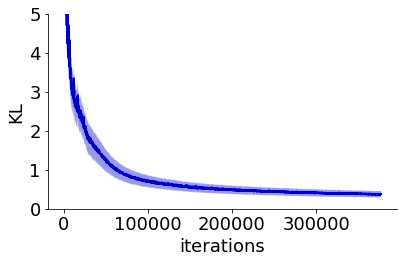

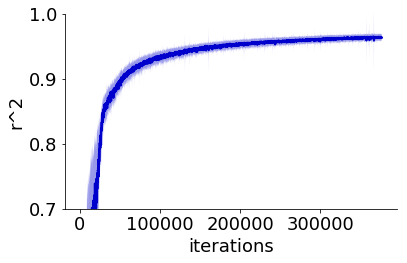

In [2]:
fontsize = 18;
red = [.8,0,0];
blue = [0,0,.8];
its = np.arange(0, check_rate*final_ind, check_rate);

plt.figure();
# KL
plt.plot(its, mean_KLs, color=blue, lw=2);
min_val = np.min(mean_KLs-std_KLs);
if (model=='EFN'):
    plt.fill_between(its, mean_KLs+std_KLs, mean_KLs-std_KLs,facecolor=blue, alpha=0.4,);
    std_mag = np.max(std_KLs);
    max_val = min_val + 3*std_mag;
else:
    max_val = np.max(mean_KLs);
plt.ylim([0.0, 5.0])
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel('KL', fontsize=fontsize);
ax = plt.gca();
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout();
plt.savefig('/Users/sbittner/Documents/efn/written/EFN_AISTATS2019/figs/fig2/2a.pdf', dpi=300, transparent=True, )
plt.show();

# r2
plt.figure();
plt.plot(its, mean_R2s,color=blue, lw=2);
min_val = max(np.min(mean_R2s-std_R2s), 0);
if (model=='EFN'):
    plt.fill_between(its, mean_R2s+std_R2s, mean_R2s-std_R2s,facecolor=blue, alpha=0.4,);
plt.ylim([.7, 1])
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel('r^2', fontsize=fontsize);
ax = plt.gca();
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout();
plt.savefig('/Users/sbittner/Documents/efn/written/EFN_AISTATS2019/figs/fig2/2b.pdf', dpi=300, transparent=True, )

plt.show();

In [3]:
Z = npzfile['X'];
eta = npzfile['eta'];
params = npzfile['params'][()];
K_eta = len(params);

In [4]:
def MMD2u(K, m, n):
    """The MMD^2_u unbiased statistic.
    """
    Kx = K[:m, :m]
    Ky = K[m:, m:]
    Kxy = K[:m, m:]
    return 1.0 / (m * (m - 1.0)) * (Kx.sum() - Kx.diagonal().sum()) + \
        1.0 / (n * (n - 1.0)) * (Ky.sum() - Ky.diagonal().sum()) - \
        2.0 / (m * n) * Kxy.sum()


def compute_null_distribution(K, m, n, iterations=10000, verbose=False,
                              random_state=None, marker_interval=1000):
    """Compute the bootstrap null-distribution of MMD2u.
    """
    if type(random_state) == type(np.random.RandomState()):
        rng = random_state
    else:
        rng = np.random.RandomState(random_state)

    mmd2u_null = np.zeros(iterations)
    for i in range(iterations):
        if verbose and (i % marker_interval) == 0:
            print(i),
            stdout.flush()
        idx = rng.permutation(m+n)
        K_i = K[idx, idx[:, None]]
        mmd2u_null[i] = MMD2u(K_i, m, n)

    if verbose:
        print("")

    return mmd2u_null


def kernel_two_sample_test(X, Y, kernel_function='rbf', iterations=10000,
                           verbose=False, random_state=None, **kwargs):
    """Compute MMD^2_u, its null distribution and the p-value of the
    kernel two-sample test.
    Note that extra parameters captured by **kwargs will be passed to
    pairwise_kernels() as kernel parameters. E.g. if
    kernel_two_sample_test(..., kernel_function='rbf', gamma=0.1),
    then this will result in getting the kernel through
    kernel_function(metric='rbf', gamma=0.1).
    """
    m = len(X)
    n = len(Y)
    XY = np.vstack([X, Y])
    K = pairwise_kernels(XY, metric=kernel_function, **kwargs)
    mmd2u = MMD2u(K, m, n)
    if verbose:
        print("MMD^2_u = %s" % mmd2u)
        print("Computing the null distribution.")

    mmd2u_null = compute_null_distribution(K, m, n, iterations,
                                           verbose=verbose,
                                           random_state=random_state)
    p_value = max(1.0/iterations, (mmd2u_null > mmd2u).sum() /
                  float(iterations))
    if verbose:
        print("p-value ~= %s \t (resolution : %s)" % (p_value, 1.0/iterations))

    return mmd2u, mmd2u_null, p_value

In [5]:
from scipy.stats import dirichlet

alpha = np.array([1,2,3]);
dist = dirichlet(alpha);
x = dist.rvs(100);
print(x.shape);


(100, 3)


In [6]:
from sklearn.metrics import pairwise_distances
from sys import stdout
from sklearn.metrics import pairwise_kernels

n = 100;
pvalfname = savedir + 'pvals_n=%d.npz' % n;

if (os.path.isfile(pvalfname)):
    pvalfile = np.load(pvalfname);
    pvals = pvalfile['pvals'];
else:
    n_mmds = K_eta;
    pvals = np.zeros((n_mmds,));
    for ind in range(n_mmds):
        X = Z[ind,:n,:,0];
        alpha = params[ind]['alpha'];
        dist = dirichlet(alpha);
        Y = dist.rvs(n);
        sigma2 = np.median(pairwise_distances(X, Y, metric='euclidean'))**2
        mmd2u, mmd2u_null, p_value = kernel_two_sample_test(X, Y,
                                                            kernel_function='rbf',
                                                            gamma=1.0/sigma2,
                                                            verbose=True)
        pvals[ind] = p_value;
        
    np.savez(pvalfname, pvals=pvals);

/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


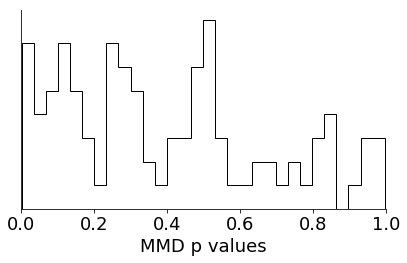

In [14]:
plt.figure();
plt.hist(pvals, 30, histtype='step', normed=True, color='k');
plt.xlabel('MMD p values', fontsize=fontsize);
plt.xlim([0, 1]);
ax = plt.gca();
ax.set_yticks([]);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('/Users/sbittner/Documents/efn/written/EFN_AISTATS2019/figs/fig2/2c.pdf', dpi=300, transparent=True, )
plt.show();

/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


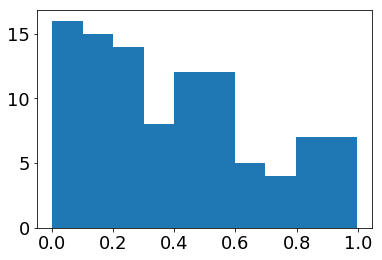

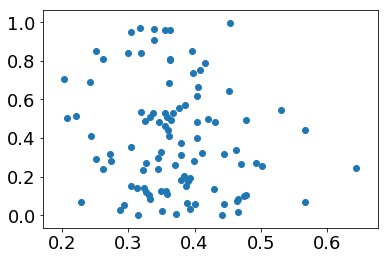

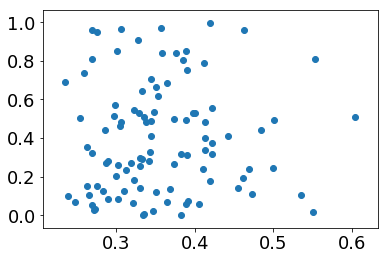

In [8]:
test_KLs = npzfile['test_KLs'];
train_KLs = npzfile['train_KLs'];

plt.figure();
plt.hist(pvals)
plt.show();

plt.figure();
plt.scatter(test_KLs[final_ind], pvals)
plt.show();

plt.figure();
plt.scatter(train_KLs[final_ind], pvals)
plt.show();